In [1]:
import os
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
from bs4 import BeautifulSoup as bs

In [2]:
models = ["iIT341", "iML1515", "iNJ661", "iPC815", "iYL1228", "STM_v1_0"]
os.chdir('../examples')

In [4]:
def get_data(model):
    df = pd.read_csv(model + '/' + model + '_pFBA.csv')
    df = df.replace(["GLCtex_copy1", "GLCtex_copy2"], "GLCtex")
    rxns = list(df['Rxn_1'].unique())
    rxns.extend(list(df['Rxn_2'].unique()))
    rxns = list(set(rxns))
    types = {}
    
    if 'UMPK_copy2' in rxns:
        types['UMPK_copy2'] = 'Pyrimidine Metabolism'
        rxns.remove('UMPK_copy2')
    if 'UMPK_copy1' in rxns:
        types['UMPK_copy1'] = 'Nucleotide Sugar Metabolism'
        rxns.remove('UMPK_copy1')
    
    for i in tqdm(rxns):
        url = 'http://bigg.ucsd.edu/models/' + model + '/reactions/' + i
        source = requests.get(url).text
        soup = bs(source, 'lxml')

        values = {}
        for data in soup.find_all('div', class_='col-lg-8'):
            all_h4 = [i.text for i in data.find_all('h4')]
            all_p = [i.text for i in data.find_all('p')]
            all_h4.remove('Metabolites:')

            for h4,p in zip(all_h4, all_p):
                values[h4[:-1]] = p
            values[h4[:-1]] = p.split("\n")[1]
        
        if 'Subsystem' not in values.keys():
            print(i, url, values)
        types[i] = values['Subsystem']
    
    subsystems1 = [types[i] for i in df['Rxn_1']]
    subsystems2 = [types[i] for i in df['Rxn_2']]
    df["Subsystem 1"] = subsystems1
    df["Subsystem 2"] = subsystems2
    
    return df

for i in range(len(models)):
    print(models[i])
    df = get_data(models[i])
    df.to_csv(models[i]+'_submodules.csv')

  0%|          | 0/65 [00:00<?, ?it/s]

iIT341


  0%|          | 0/166 [00:00<?, ?it/s]

iML1515


  0%|          | 0/87 [00:00<?, ?it/s]

iNJ661


  0%|          | 0/161 [00:00<?, ?it/s]

iPC815


  0%|          | 0/144 [00:00<?, ?it/s]

iYL1228


  0%|          | 0/161 [00:00<?, ?it/s]

STM_v1_0


100%|██████████| 161/161 [01:57<00:00,  1.37it/s]


Organism: iIT341


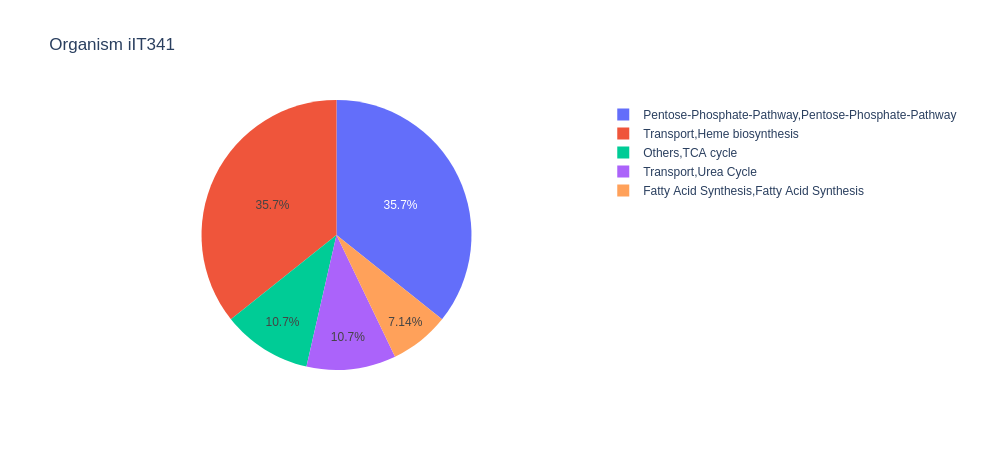

Organism: iML1515


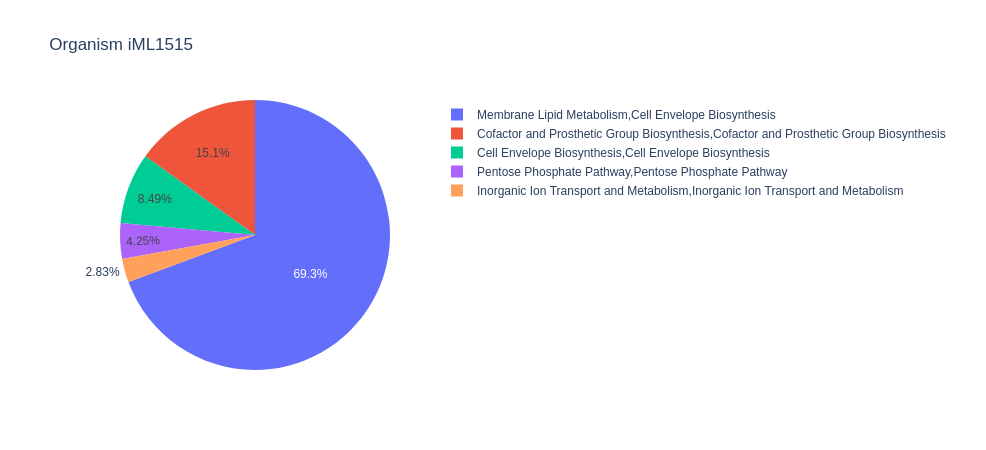

Organism: iNJ661


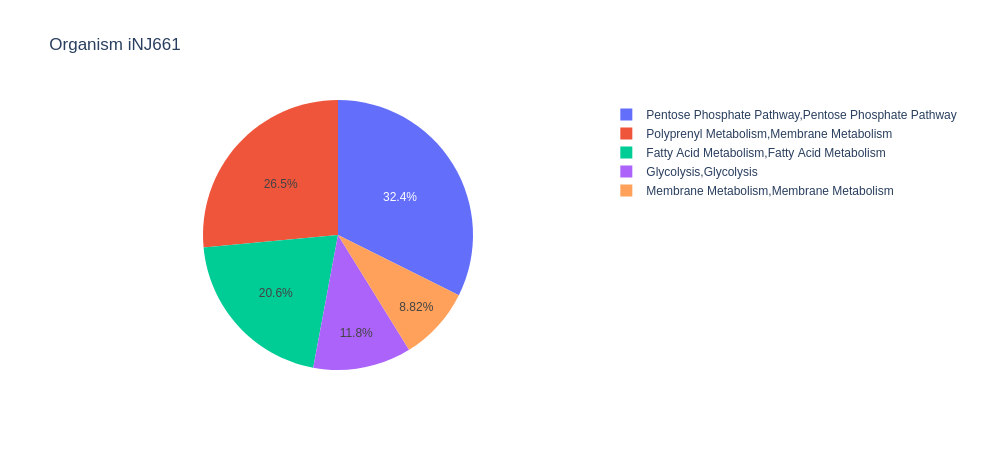

Organism: iPC815


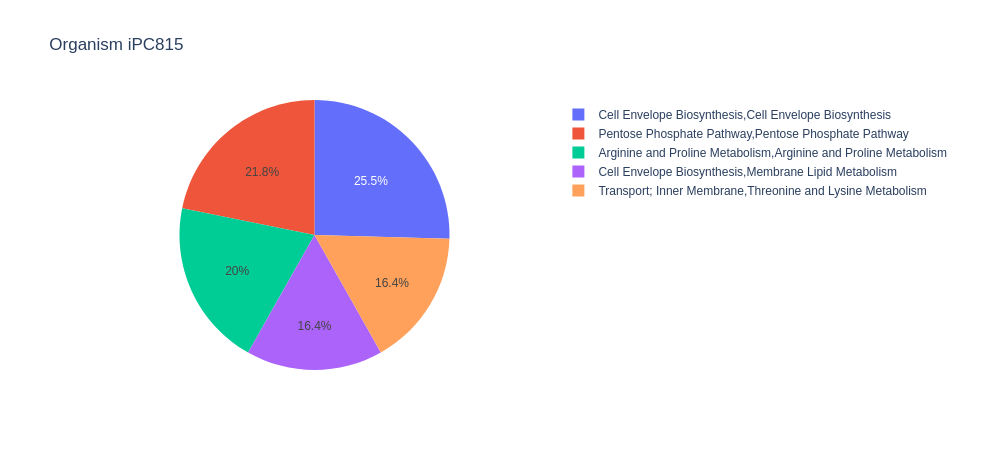

Organism: iYL1228


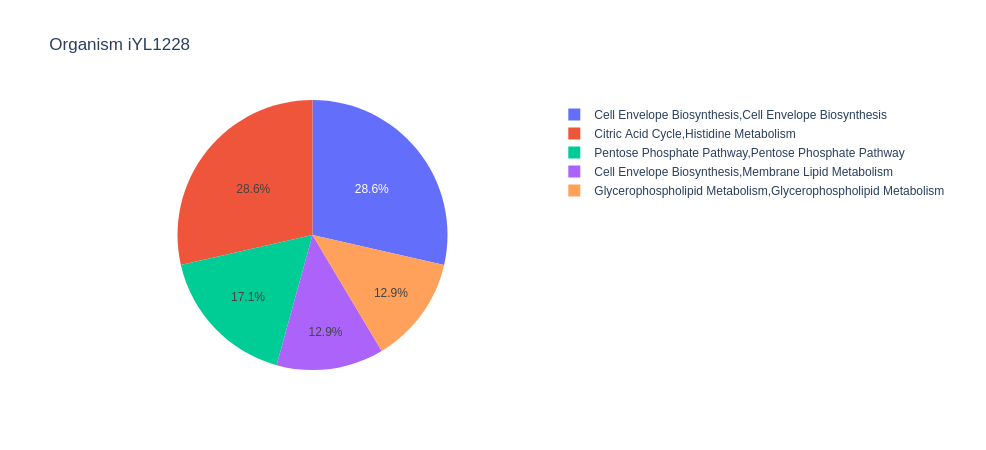

Organism: STM_v1_0


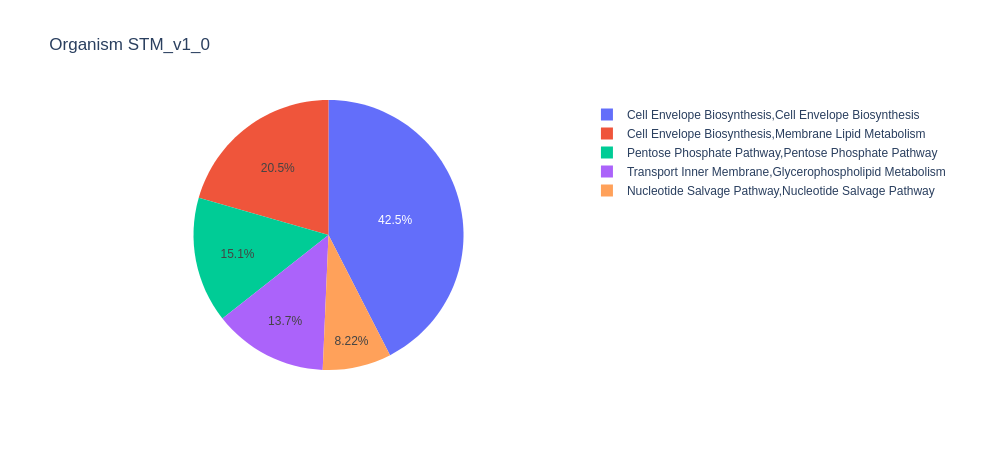

In [6]:
%matplotlib tk
for i in models:
    print("Organism:", i)
    df_new = pd.read_csv(i+'_submodules.csv')
    df_new2 = df_new.copy()
    df_new2 = df_new2.groupby(["Subsystem 1", "Subsystem 2"]).count()
    df_new2 = df_new2["Unnamed: 0"]
    df_new2 = df_new2.reset_index()
    df_new2 = df_new2.rename(columns={"Unnamed: 0":"Count"})
    df_new2["Combination"] = df_new2['Subsystem 1'] + "," + df_new2['Subsystem 2']
    df_new2.sort_values(['Count'], ascending=False, inplace=True)
    df_max = df_new2.head(5)
    
    fig = px.pie(df_max, values='Count', names='Combination', title="Organism "+i)
    fig.show()